# 1. Import Packages

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk

In [20]:
import re
import string

In [21]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score

In [23]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
import xgboost
from xgboost import XGBClassifier

In [26]:
# create empty list at beginning of every jupyter notebook
hyperparameter_table  = []

# 2. Load Datasets

In [27]:
# load dataset
news = pd.read_csv('../Data/news_classification_Feb06_24.csv', index_col=0, parse_dates=['date', 'election_day'])
news.head()

,title,text,subject,date,label,char_count_text,word_count_text,avg_word_length_text,char_count_title,word_count_title,avg_word_length_title,year,month,day,day_of_week,election_day,days_to_election
22216,Ben Stein Calls Out 9th Circuit Court: Committ...,"21st Century Wire says Ben Stein, reputable pr...",US_News,2017-02-13,fake_news,1028,171,6.011696,89,14,6.357143,2017,2,13,0,2016-11-08,97
27917,Trump drops Steve Bannon from National Securit...,WASHINGTON (Reuters) - U.S. President Donald T...,politicsNews,2017-04-05,real_news,4820,771,6.251621,55,8,6.875000,2017,4,5,2,2016-11-08,148
25007,Puerto Rico expects U.S. to lift Jones Act shi...,(Reuters) - Puerto Rico Governor Ricardo Rosse...,politicsNews,2017-09-27,real_news,1848,304,6.078947,64,10,6.400000,2017,9,27,2,2016-11-08,323
1377,OOPS: Trump Just Accidentally Confirmed He Le...,"On Monday, Donald Trump once again embarrassed...",News,2017-05-22,fake_news,1244,183,6.797814,89,12,7.416667,2017,5,22,0,2016-11-08,195
32476,Donald Trump heads for Scotland to reopen a go...,"GLASGOW, Scotland (Reuters) - Most U.S. presid...",politicsNews,2016-06-24,real_news,3137,529,5.930057,55,10,5.500000,2016,6,24,4,2016-11-08,-137


In [28]:
# check shape, rows and columns
news.shape

(37924, 17)

In [29]:
# check column names
news.columns

Index(['title', 'text', 'subject', 'date', 'label', 'char_count_text',
       'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'month', 'day',
       'day_of_week', 'election_day', 'days_to_election'],
      dtype='object')

In [30]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37924 entries, 22216 to 28254
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  37924 non-null  object        
 1   text                   37924 non-null  object        
 2   subject                37924 non-null  object        
 3   date                   37924 non-null  datetime64[ns]
 4   label                  37924 non-null  object        
 5   char_count_text        37924 non-null  int64         
 6   word_count_text        37924 non-null  int64         
 7   avg_word_length_text   37924 non-null  float64       
 8   char_count_title       37924 non-null  int64         
 9   word_count_title       37924 non-null  int64         
 10  avg_word_length_title  37924 non-null  float64       
 11  year                   37924 non-null  int64         
 12  month                  37924 non-null  int64         
 13  da

In [31]:
news['month'] = news['month'].map({1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',\
                                  7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'})
news['day_of_week'] = news['day_of_week'].map({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday',\
                                               5:'Saturday', 6:'Sunday'})

In [32]:
news.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37924 entries, 22216 to 28254
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  37924 non-null  object        
 1   text                   37924 non-null  object        
 2   subject                37924 non-null  object        
 3   date                   37924 non-null  datetime64[ns]
 4   label                  37924 non-null  object        
 5   char_count_text        37924 non-null  int64         
 6   word_count_text        37924 non-null  int64         
 7   avg_word_length_text   37924 non-null  float64       
 8   char_count_title       37924 non-null  int64         
 9   word_count_title       37924 non-null  int64         
 10  avg_word_length_title  37924 non-null  float64       
 11  year                   37924 non-null  int64         
 12  month                  37924 non-null  object        
 13  da

# 3. Data Preprocessing and Modeling
**Two methods will be used for modeling:**

**The method 1 use features new created including character count, word count, average word length in title and text, year, month, day, day of week and days to election.**

**The method 2 use only the text column and vectorize with CountVectorizer() or TfidfVectorizer() with different parameters like ngram_range, max_df and min_df.**

## 3.1 Data Preparation

In [33]:
X = news[['char_count_text', 'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'month', 'day', 'day_of_week', 'days_to_election']]
y = news.label
# get dummy of categorical variables
X = pd.get_dummies(X)

In [34]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 37924 entries, 22216 to 28254
Data columns (total 28 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   char_count_text        37924 non-null  int64  
 1   word_count_text        37924 non-null  int64  
 2   avg_word_length_text   37924 non-null  float64
 3   char_count_title       37924 non-null  int64  
 4   word_count_title       37924 non-null  int64  
 5   avg_word_length_title  37924 non-null  float64
 6   year                   37924 non-null  int64  
 7   day                    37924 non-null  int64  
 8   days_to_election       37924 non-null  int64  
 9   month_Apr              37924 non-null  bool   
 10  month_Aug              37924 non-null  bool   
 11  month_Dec              37924 non-null  bool   
 12  month_Feb              37924 non-null  bool   
 13  month_Jan              37924 non-null  bool   
 14  month_Jul              37924 non-null  bool   
 15  mon

In [35]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [36]:
# check shapes
X_train.shape, X_test.shape

((26546, 28), (11378, 28))

## 3.2 Modeling

### 3.2.1 Method_1 Exp_1 Logistic Regression

In [37]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [38]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit model
lr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [39]:
# get train_score using cross validation in 5 folds
train_accuracy = np.mean(cross_val_score(lr_classifier, X_train, y_train, cv=5))

In [40]:
y_test_pred = lr_classifier.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [41]:
parameters = dict(Exp=1, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=9,\
                  n_Cat=2, Cat_Encode='pd.get_dimmies()', Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,2), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)

In [42]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision
Exp,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.89,0.891,0.921,0.886


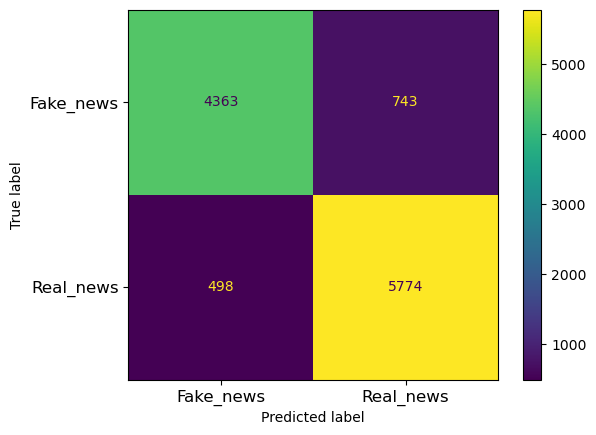

In [43]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.2.2 Method_1 Exp_2 Random Forest Classifier

In [44]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [45]:
# initiate the model
rf_classifier = RandomForestClassifier()
# fit model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier()

In [46]:
# get train_score using cross validation in 5 folds
train_accuracy = np.mean(cross_val_score(rf_classifier, X_train, y_train, cv=5))

In [47]:
y_test_pred = rf_classifier.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [48]:
parameters = dict(Exp=2, Model_Name='RandomForest Classifier', Drop_Dup='Yes', n_Num=9,\
                  n_Cat=2, Cat_Encode='pd.get_dimmies()', Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)

In [49]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision
Exp,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915


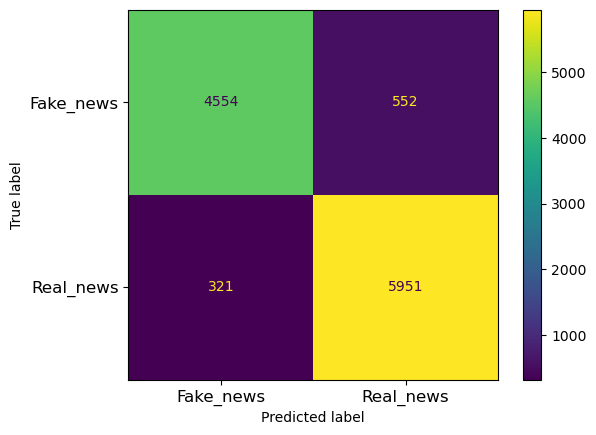

In [50]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = rf_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.2.3 Method_1 Exp_3 Gradient Boost Classifier

In [51]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [52]:
# initiate the model
gb_classifier = GradientBoostingClassifier()
# fit model
gb_classifier.fit(X_train, y_train)

GradientBoostingClassifier()

In [53]:
# get train_score using cross validation in 5 folds
train_accuracy = np.mean(cross_val_score(gb_classifier, X_train, y_train, cv=5))

In [54]:
y_test_pred = gb_classifier.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [55]:
parameters = dict(Exp=3, Model_Name='GradientBoost Classifier', Drop_Dup='Yes', n_Num=9,\
                  n_Cat=2, Cat_Encode='pd.get_dimmies()', Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)

In [56]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision
Exp,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910


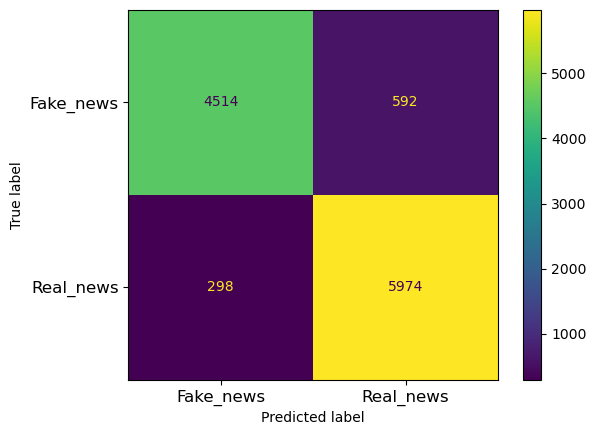

In [57]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = gb_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.2.4 Method_1 Exp_4 XGBoost Classifier

In [58]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [59]:
y_train_xgb = y_train.map({'fake_news':0, 'real_news':1})
y_test_xgb = y_test.map({'fake_news':0, 'real_news':1})

In [60]:
# initiate the model
xgb_classifier = XGBClassifier()
# fit model
xgb_classifier.fit(X_train, y_train_xgb)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [61]:
# get train_score using cross validation in 5 folds
train_accuracy = np.mean(cross_val_score(xgb_classifier, X_train, y_train_xgb, cv=5))

In [62]:
y_test_pred = xgb_classifier.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test_xgb, y_test_pred)
test_recall = metrics.recall_score(y_test_xgb, y_test_pred)
test_precision = metrics.precision_score(y_test_xgb, y_test_pred)

In [63]:
parameters = dict(Exp=4, Model_Name='XGBoost Classifier', Drop_Dup='Yes', n_Num=9,\
                  n_Cat=2, Cat_Encode='pd.get_dimmies()', Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)

In [64]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision
Exp,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913


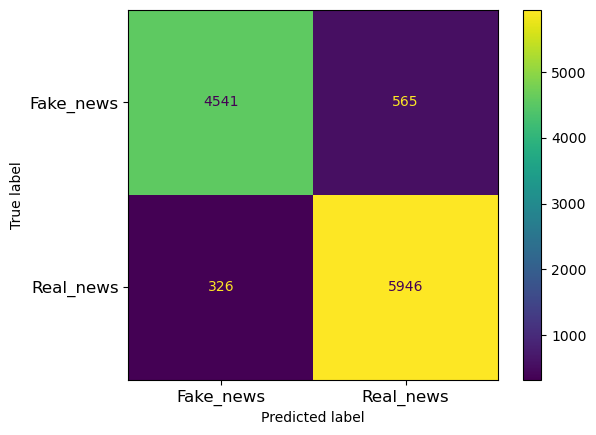

In [65]:
cm = metrics.confusion_matrix(y_test_xgb, y_test_pred, labels = xgb_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

## 3.2.5 Method_2 Exp_5 Logistic Regression with CountVectorizer

In [66]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [67]:
# assign X and y
X = news.text
y = news.label

In [68]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1))
count_vectorizer = CountVectorizer(**cv_kwargs)

In [69]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [70]:
count_X_train.shape, count_X_test.shape

((26546, 102155), (11378, 102155))

In [71]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [72]:
train_accuracy = np.mean(cross_val_score(lr_classifier, count_X_train, y_train, cv=5))

In [73]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [74]:
parameters = dict(Exp=5, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=0,\
                  n_Cat=1, Cat_Encode='CountVectorizer()', n_Vector=count_X_train.shape[1], Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3))

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [75]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range
Exp,,,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886,NaN,NaN
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910,NaN,NaN
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913,NaN,NaN
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)"


In [76]:
coef = pd.Series(lr_classifier.coef_[0], index=count_vectorizer.get_feature_names_out())

In [77]:
coef.sort_values().tail()

reporters     0.517775
wednesday     0.610461
said          0.633749
washington    0.880544
reuters       6.506091
dtype: float64

In [78]:
coef.sort_values().head()

via     -2.189670
read    -1.192046
com     -0.776250
watch   -0.745857
just    -0.718610
dtype: float64

## 3.2.6 Method_2 Exp_6 Logistic Regression with CountVectorizer

In [79]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [80]:
# remove news sources, especially locations and reuters
news['text'] = news['text'].apply(lambda x: x.split('-', 1)[1].strip()\
                                        if 'Reuters' in x and '-' in x and len(x.split('-')) > 1 else x)
# remove all reuters
news['text'] = news['text'].str.replace(r'Reuters|reuters|REUTERS', '', regex=True)

In [81]:
def remove_last_sentence(text):
        sentences = nltk.sent_tokenize(text)
        sentence = sentences[:-1] if sentences else ""
        return ''.join(sentence)

# remove news note, which is always last sentence.
news['text'] = news['text'].apply(remove_last_sentence)

In [82]:
# remove empty text rows
news = news[news['text']!='']

In [83]:
# assign X and y
X = news.text
y = news.label

In [84]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1))
count_vectorizer = CountVectorizer(**cv_kwargs)

In [85]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [86]:
count_X_train.shape, count_X_test.shape

((26282, 96848), (11264, 96848))

In [87]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [88]:
train_accuracy = np.mean(cross_val_score(lr_classifier, count_X_train, y_train, cv=5))

In [89]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [90]:
parameters = dict(Exp=6, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=0,\
                  n_Cat=1, Cat_Encode='CountVectorizer()', n_Vector=count_X_train.shape[1], Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3), Del_HCoff='Yes')

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [91]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range,Del_HCoff
Exp,,,,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886,NaN,NaN,NaN
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN,NaN
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910,NaN,NaN,NaN
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913,NaN,NaN,NaN
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)",NaN
6,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.973,0.973,0.980,0.972,96848.0,"(1, 1)",Yes


In [92]:
coef = pd.Series(lr_classifier.coef_[0], index=count_vectorizer.get_feature_names_out())

In [93]:
coef.sort_values().tail()

friday       1.564306
wednesday    1.731131
thursday     1.794129
est          1.808553
edt          2.013001
dtype: float64

In [94]:
coef.sort_values().head()

sen       -1.549458
com       -1.546408
gop       -1.486577
rep       -1.312546
morning   -1.207372
dtype: float64

## 3.2.7 Method_2 Exp_7 Logistic Regression with CountVectorizer

In [95]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [96]:
# assign X and y
X = news.text
y = news.label

In [97]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1), max_df=0.8)
count_vectorizer = CountVectorizer(**cv_kwargs)

In [98]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [99]:
count_X_train.shape, count_X_test.shape

((26282, 96840), (11264, 96840))

In [100]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [101]:
train_accuracy = np.mean(cross_val_score(lr_classifier, count_X_train, y_train, cv=5))

In [102]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [103]:
parameters = dict(Exp=7, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=0,\
                  n_Cat=1, Cat_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5, Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3), Del_HCoff='Yes')

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [104]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range,Del_HCoff,max_df
Exp,,,,,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886,NaN,NaN,NaN,NaN
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910,NaN,NaN,NaN,NaN
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913,NaN,NaN,NaN,NaN
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)",NaN,NaN
6,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.973,0.973,0.980,0.972,96848.0,"(1, 1)",Yes,NaN
7,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.972,0.972,0.979,0.971,96840.0,"(1, 1)",Yes,0.8


In [105]:
coef = pd.Series(lr_classifier.coef_[0], index=count_vectorizer.get_feature_names_out())

In [106]:
coef.sort_values().tail()

tuesday      1.970595
friday       1.998578
edt          2.040061
wednesday    2.127020
thursday     2.206799
dtype: float64

In [107]:
coef.sort_values().head()

sen     -1.670540
gop     -1.623264
com     -1.591029
night   -1.377433
rep     -1.352077
dtype: float64

## 3.2.8 Method_2 Exp_8 Logistic Regression with CountVectorizer

In [108]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [109]:
# assign X and y
X = news.text
y = news.label

In [110]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1), min_df=0.1)
count_vectorizer = CountVectorizer(**cv_kwargs)

In [111]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [112]:
count_X_train.shape, count_X_test.shape

((26282, 301), (11264, 301))

In [113]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [114]:
train_accuracy = np.mean(cross_val_score(lr_classifier, count_X_train, y_train, cv=5))

In [115]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [116]:
parameters = dict(Exp=8, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=0,\
                  n_Cat=1, Cat_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3), Del_HCoff='Yes')

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [117]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.973,0.973,0.980,0.972,96848.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.972,0.972,0.979,0.971,96840.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.952,0.949,0.964,0.944,301.0,"(1, 1)",Yes,NaN,0.1


In [118]:
coef = pd.Series(lr_classifier.coef_[0], index=count_vectorizer.get_feature_names_out())

In [119]:
coef.sort_values().tail()

month       0.653061
said        0.690927
thursday    0.764863
barack      0.795970
minister    0.867172
dtype: float64

In [120]:
coef.sort_values().head()

didn      -1.040514
hillary   -0.828717
us        -0.802945
just      -0.801239
fact      -0.639131
dtype: float64

## 3.2.9 Method_2 Exp_9 Logistic Regression with CountVectorizer

In [121]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [122]:
# assign X and y
X = news.text
y = news.label

In [123]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1), max_df=0.8, min_df=0.1)
count_vectorizer = CountVectorizer(**cv_kwargs)

In [124]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [125]:
count_X_train.shape, count_X_test.shape

((26282, 293), (11264, 293))

In [126]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [127]:
train_accuracy = np.mean(cross_val_score(lr_classifier, count_X_train, y_train, cv=5))

In [128]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [129]:
parameters = dict(Exp=9, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=0,\
                  n_Cat=1, Cat_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3), Del_HCoff='Yes')

hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [130]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.973,0.973,0.980,0.972,96848.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.972,0.972,0.979,0.971,96840.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.952,0.949,0.964,0.944,301.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.948,0.944,0.962,0.938,293.0,"(1, 1)",Yes,0.8,0.1


In [131]:
coef = pd.Series(lr_classifier.coef_[0], index=count_vectorizer.get_feature_names_out())

In [132]:
coef.sort_values().tail()

wednesday    0.735477
tuesday      0.751362
barack       0.818739
thursday     0.851579
minister     0.922056
dtype: float64

In [133]:
coef.sort_values().head()

didn      -1.073228
hillary   -0.874395
just      -0.800113
us        -0.782454
fact      -0.727684
dtype: float64

## 3.2.10 Method_2 Exp_10 Logistic Regression with CountVectorizer

In [134]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [135]:
# assign X and y
X = news.text
y = news.label

In [136]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(2,2), max_df=0.8, min_df=0.1)
count_vectorizer = CountVectorizer(**cv_kwargs)

In [137]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [138]:
count_X_train.shape, count_X_test.shape

((26282, 92), (11264, 92))

In [139]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [140]:
train_accuracy = np.mean(cross_val_score(lr_classifier, count_X_train, y_train, cv=5))

In [141]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [142]:
parameters = dict(Exp=10, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=0,\
                  n_Cat=1, Cat_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3), Del_HCoff='Yes')


hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [143]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.973,0.973,0.980,0.972,96848.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.972,0.972,0.979,0.971,96840.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.952,0.949,0.964,0.944,301.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.948,0.944,0.962,0.938,293.0,"(1, 1)",Yes,0.8,0.1


In [144]:
coef = pd.Series(lr_classifier.coef_[0], index=count_vectorizer.get_feature_names_out())

In [145]:
coef.sort_values().tail()

on tuesday          1.801004
on thursday         1.822316
on wednesday        1.894054
president donald    2.211780
said on             2.490849
dtype: float64

In [146]:
coef.sort_values().head()

this is        -0.960949
that they      -0.786559
donald trump   -0.696774
that he        -0.571227
that the       -0.555045
dtype: float64

## 3.2.11 Method_2 Exp_11 Logistic Regression with CountVectorizer

In [147]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [148]:
# assign X and y
X = news.text
y = news.label

In [149]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,2), max_df=0.8, min_df=0.1)
count_vectorizer = CountVectorizer(**cv_kwargs)

In [150]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [151]:
count_X_train.shape, count_X_test.shape

((26282, 385), (11264, 385))

In [152]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [153]:
train_accuracy = np.mean(cross_val_score(lr_classifier, count_X_train, y_train, cv=5))

In [154]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [155]:
parameters = dict(Exp=11, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=0,\
                  n_Cat=1, Cat_Encode='CountVectorizer()',  n_Vector=count_X_train.shape[1], Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3), Del_HCoff='Yes')


hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [156]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.973,0.973,0.980,0.972,96848.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.972,0.972,0.979,0.971,96840.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.952,0.949,0.964,0.944,301.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.948,0.944,0.962,0.938,293.0,"(1, 1)",Yes,0.8,0.1


In [157]:
coef = pd.Series(lr_classifier.coef_[0], index=count_vectorizer.get_feature_names_out())

In [158]:
coef.sort_values().tail()

barack obama    2.356348
on monday       2.622073
on tuesday      2.670819
on thursday     2.695337
on wednesday    2.870800
dtype: float64

In [159]:
coef.sort_values().head()

wednesday   -1.207124
barack      -1.195135
monday      -0.988843
hillary     -0.987733
said that   -0.955529
dtype: float64

## 3.2.12 Method_2 Exp_12 Logistic Regression with CountVectorizer

In [160]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [161]:
# assign X and y
X = news.text
y = news.label

In [162]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,2), max_df=0.8, min_df=0.2)
count_vectorizer = CountVectorizer(**cv_kwargs)

In [163]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [164]:
count_X_train.shape, count_X_test.shape

((26282, 144), (11264, 144))

In [165]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression(max_iter=1000)

In [166]:
train_accuracy = np.mean(cross_val_score(lr_classifier, count_X_train, y_train, cv=5))

In [167]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [168]:
parameters = dict(Exp=12, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=0,\
                  n_Cat=1, Cat_Encode='CountVectorizer()', n_Vector=count_X_train.shape[1], Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3), Del_HCoff='Yes')


hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [169]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.973,0.973,0.980,0.972,96848.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.972,0.972,0.979,0.971,96840.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.952,0.949,0.964,0.944,301.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.948,0.944,0.962,0.938,293.0,"(1, 1)",Yes,0.8,0.1


In [170]:
coef = pd.Series(lr_classifier.coef_[0], index=count_vectorizer.get_feature_names_out())

In [171]:
coef.sort_values().tail()

told          0.377911
republican    0.385880
the united    0.599959
said          0.695537
said on       2.136276
dtype: float64

In [172]:
coef.sort_values().head()

just        -0.770907
even        -0.555857
that the    -0.533658
this        -0.521981
according   -0.482129
dtype: float64

## 3.2.13 Method_2 Exp_13 Logistic Regression with TfidfVectorizer

In [173]:
# create empty dict at start of every experiment. 
hyperparameters = {}
hyperparameter_table.append(hyperparameters)

In [174]:
# assign X and y
X = news.text
y = news.label

In [175]:
# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Initialize a TfidfVectorizer object: tfidf_vectorizer
cv_kwargs = dict(ngram_range=(1,2), max_df=0.8, min_df=0.1)
tfidf_vectorizer = TfidfVectorizer(**cv_kwargs)

In [176]:
# Transform the training data using only the 'text' column values: tfidf_train 
tfidf_X_train = tfidf_vectorizer.fit_transform(X_train)

# Transform the test data using only the 'text' column values: tfidf_test 
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [177]:
tfidf_X_train.shape, tfidf_X_test.shape

((26282, 385), (11264, 385))

In [178]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit the model
lr_classifier.fit(tfidf_X_train, y_train)

LogisticRegression(max_iter=1000)

In [179]:
train_accuracy = np.mean(cross_val_score(lr_classifier, tfidf_X_train, y_train, cv=5))

In [180]:
y_test_pred = lr_classifier.predict(tfidf_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [181]:
parameters = dict(Exp=13, Model_Name='Logistic Regression', Drop_Dup='Yes', n_Num=0,\
                  n_Cat=1, Cat_Encode='TfidfVectorizer()', n_Vector=tfidf_X_train.shape[1], Test_P=0.3, Scale='No',\
                  Cross_Val='Yes', CV=5,	Train_Accuracy=round(train_accuracy,3), Test_Accuracy=round(test_accuracy,3),\
                  Test_Recall=round(test_recall,3), Test_Precision=round(test_precision,3), Del_HCoff='Yes')


hyperparameter_table[-1].update(parameters)
hyperparameter_table[-1].update(cv_kwargs)

In [182]:
pd.DataFrame(hyperparameter_table).set_index('Exp')

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
1,Logistic Regression,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.890,0.891,0.921,0.886,NaN,NaN,NaN,NaN,NaN
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN,NaN,NaN,NaN
3,GradientBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.919,0.922,0.952,0.910,NaN,NaN,NaN,NaN,NaN
4,XGBoost Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.922,0.948,0.913,NaN,NaN,NaN,NaN,NaN
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.973,0.973,0.980,0.972,96848.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.972,0.972,0.979,0.971,96840.0,"(1, 1)",Yes,0.8,NaN
8,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.952,0.949,0.964,0.944,301.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.948,0.944,0.962,0.938,293.0,"(1, 1)",Yes,0.8,0.1


In [183]:
coef = pd.Series(lr_classifier.coef_[0], index=tfidf_vectorizer.get_feature_names_out())

In [184]:
coef.sort_values().tail()

on thursday      6.938134
said on          7.196461
on tuesday       7.264420
on wednesday     7.334766
said            13.490131
dtype: float64

In [185]:
coef.sort_values().head()

this       -6.824388
just       -6.024905
us         -4.950278
didn       -4.752580
that the   -4.415943
dtype: float64

## 3.3 Performance Test
### 3.3.1 Data Preparation

In [189]:
pd.DataFrame(hyperparameter_table).set_index('Exp').sort_values('Test_Accuracy', ascending=False)

,Model_Name,Drop_Dup,n_Num,n_Cat,Cat_Encode,Test_P,Scale,Cross_Val,CV,Train_Accuracy,Test_Accuracy,Test_Recall,Test_Precision,n_Vector,ngram_range,Del_HCoff,max_df,min_df
Exp,,,,,,,,,,,,,,,,,,
5,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.994,0.994,0.997,0.993,102155.0,"(1, 1)",NaN,NaN,NaN
6,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.973,0.973,0.980,0.972,96848.0,"(1, 1)",Yes,NaN,NaN
7,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.972,0.972,0.979,0.971,96840.0,"(1, 1)",Yes,0.8,NaN
11,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.959,0.959,0.967,0.959,385.0,"(1, 2)",Yes,0.8,0.1
13,Logistic Regression,Yes,0,1,TfidfVectorizer(),0.3,No,Yes,5,0.960,0.958,0.968,0.956,385.0,"(1, 2)",Yes,0.8,0.1
8,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.952,0.949,0.964,0.944,301.0,"(1, 1)",Yes,NaN,0.1
9,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.948,0.944,0.962,0.938,293.0,"(1, 1)",Yes,0.8,0.1
12,Logistic Regression,Yes,0,1,CountVectorizer(),0.3,No,Yes,5,0.932,0.931,0.950,0.927,144.0,"(1, 2)",Yes,0.8,0.2
2,RandomForest Classifier,Yes,9,2,pd.get_dimmies(),0.3,No,Yes,5,0.918,0.923,0.949,0.915,NaN,NaN,NaN,NaN,NaN


**From the table, we can conclude that:**

**1. The best model is Method_2 Exp_5 Logistic Regression with CountVectorizer(), ngram=1, and default max_df and min_df. The problem is there are several high coefficient vectors play an import role in the prediction, like reuters or some locations, these information mainly come as news sources.**   

**2. Method_2 Exp_6, from Exp_5, only remove these high coefficient vectors, the accuracy is little bit lower, but not much, the accuracy is 0.973.** 

**3. Method_2 Exp_7, from Exp_6, only using max_df=0.8 didn't change the result much and the vectors only 5% less, the accuracy is 0.972, lower than without using 0.973.**

**4. Method_2 Exp_8, from Exp_6, only using min_df=0.1 decrease the vector a lot (more than 95%), the accuracy is 0.949, lower than without using 0.973.** 

**5. Method_2 Exp_9, from Exp_6, using both max_df=0.8 and min_df=0.1, the accuracy is 0.944 lower than only use one or without use.**

**6. Method_2 Exp_11, from Exp_6, using both max_df=0.8 and min_df=0.1, change ngrams to (1,2), the accuracy is 0.959 higher than use nagram=1.** 

**7. Method_1 Exp_1 to Exp_4 have no big difference.**

**Get real news from reuters, cnn and npr.**     
**Get fake news from breitbart and thegatewaypundit.**    
**Totally 25 news**

In [190]:
test = pd.read_csv('../Data/test_set_Feb29_2024.csv', parse_dates=['date'])
test

,title,text,label,source,url,date
0,Exclusive: Former Biden Aide Paid Fani Willis’...,The money flow is significant because sources ...,fake_news,breitbart,https://www.breitbart.com/politics/2024/02/29/...,2024-02-29
1,Judges in Trump-related cases face unprecedent...,U.S.District Judge Royce Lamberth has been thr...,real_news,reuters,https://www.reuters.com/investigates/special-r...,2024-02-29
2,Meet the Experienced Democrat Operative the Bi...,The Biden regime’s collusion with corrupt Fult...,fake_news,thegatewaypundit,https://www.thegatewaypundit.com/2024/02/meet-...,2024-02-26
3,Biden pressures Trump to unblock migrant plan ...,"U.S. President Joe Biden and Donald Trump, his...",real_news,reuters,https://www.reuters.com/world/us/biden-trump-m...,2024-02-29
4,Biden and Trump’s dueling border visits will e...,Two presidents will visit the southern US bord...,real_news,cnn,https://www.cnn.com/2024/02/29/politics/border...,2024-02-29
5,WOW! Biden’s Stiff Gait as He Shuffles Along D...,"Joe Biden arrived in Brownsville, Texas on Thu...",fake_news,thegatewaypundit,https://www.thegatewaypundit.com/2024/02/wow-b...,2024-02-29
6,Biden has eight months to fix his Michigan pro...,If the Democratic voters of Michigan – and a h...,real_news,cnn,https://www.cnn.com/2024/02/28/politics/biden-...,2024-02-28
7,Some Democrats turn toward Trump in Texas bord...,"Asalia Casares, 52, is a lifelong Democrat who...",real_news,reuters,https://www.reuters.com/world/us/some-democrat...,2024-02-29
8,WAYNE ROOT: “Do You Believe in Miracles?” Some...,“Do you believe in miracles?” Remember those w...,fake_news,thegatewaypundit,https://www.thegatewaypundit.com/2024/02/wayne...,2024-02-29
9,Trump says he cannot get fair trial this year ...,Donald Trump's lawyers told a U.S. judge on Th...,real_news,reuters,https://www.reuters.com/world/us/trump-asks-de...,2024-02-29


In [191]:
test['char_count_text'] = test['text'].str.len()
test['word_count_text'] = test['text'].str.split().str.len()
test['avg_word_length_text'] = test['char_count_text']/test['word_count_text']

test['char_count_title'] = test['title'].str.len()
test['word_count_title'] = test['title'].str.split().str.len()
test['avg_word_length_title'] = test['char_count_title']/test['word_count_title']

test['year'] = test['date'].dt.year
test['month'] = test['date'].dt.month
test['day'] = test['date'].dt.day

### 3.3.2 Method_1 Test_1 

In [192]:
# assign X and y
X_train = news[['char_count_text', 'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'day']]
y_train = news.label

X_test = test[['char_count_text', 'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'day']]
y_test = test.label

In [193]:
# initiate the model
lr_classifier = LogisticRegression(max_iter=1000)
# fit model
lr_classifier.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [194]:
y_test_pred = lr_classifier.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [195]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.72
The test set precision score is 0.8
The test set recall score is 0.615


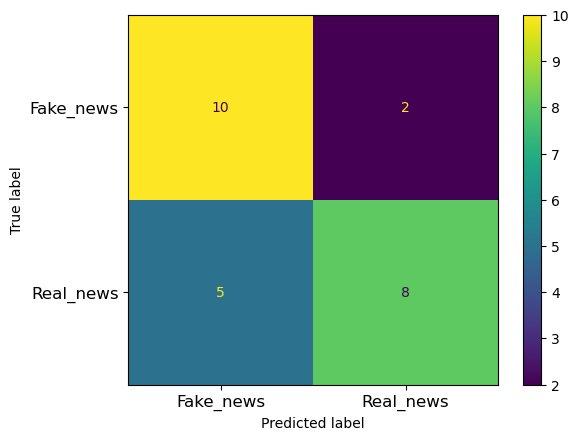

In [196]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.3.2 Method_1 Test_2

In [197]:
# assign X and y
X_train = news[['char_count_text', 'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'day']]
y_train = news.label

X_test = test[['char_count_text', 'word_count_text', 'avg_word_length_text', 'char_count_title',
       'word_count_title', 'avg_word_length_title', 'year', 'day']]
y_test = test.label

In [203]:
# initiate the model
rf_classifier = RandomForestClassifier(random_state=42)
# fit model
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [204]:
y_test_pred = rf_classifier.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [205]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.8
The test set precision score is 0.833
The test set recall score is 0.769


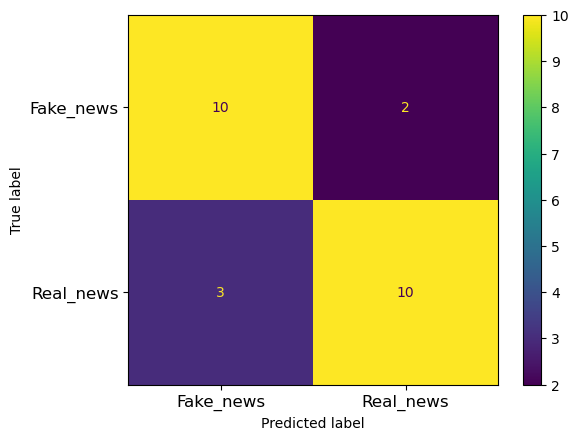

In [206]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = rf_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.3.3 Method_2 Test_3

In [207]:
# assign X and y
X_train = news.text
y_train = news.label
X_test = test.text
y_test = test.label

In [208]:
# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,1))
count_vectorizer = CountVectorizer(**cv_kwargs)

In [209]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

In [210]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [211]:
count_X_train.shape, count_X_test.shape

((37546, 115413), (25, 115413))

In [212]:
# initiate the model
lr_classifier = LogisticRegression()
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression()

In [213]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [214]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.92
The test set precision score is 1.0
The test set recall score is 0.846


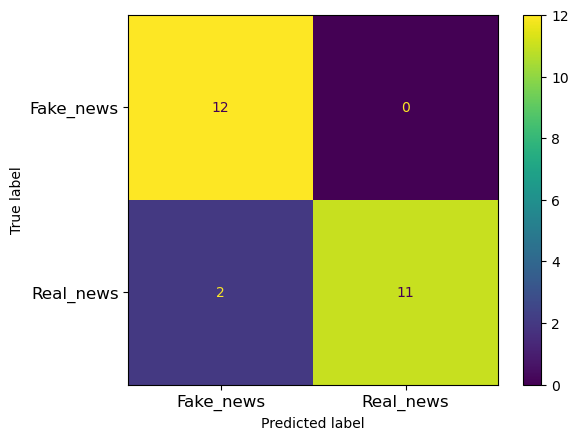

In [215]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.3.4 Method_2 Test_4

In [216]:
# assign X and y
X_train = news.text
y_train = news.label
X_test = test.text
y_test = test.label

In [217]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
cv_kwargs = dict(ngram_range=(1,1))
tfidf_vectorizer = TfidfVectorizer(**cv_kwargs)

In [218]:
# Transform the training data using only the 'text' column values: tfidf_train 
tfidf_X_train = tfidf_vectorizer.fit_transform(X_train)

In [219]:
# Transform the test data using only the 'text' column values: tfidf_test 
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [220]:
tfidf_X_train.shape, tfidf_X_test.shape

((37546, 115413), (25, 115413))

In [221]:
# initiate the model
lr_classifier = LogisticRegression()
# fit the model
lr_classifier.fit(tfidf_X_train, y_train)

LogisticRegression()

In [222]:
y_test_pred = lr_classifier.predict(tfidf_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [223]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.88
The test set precision score is 1.0
The test set recall score is 0.769


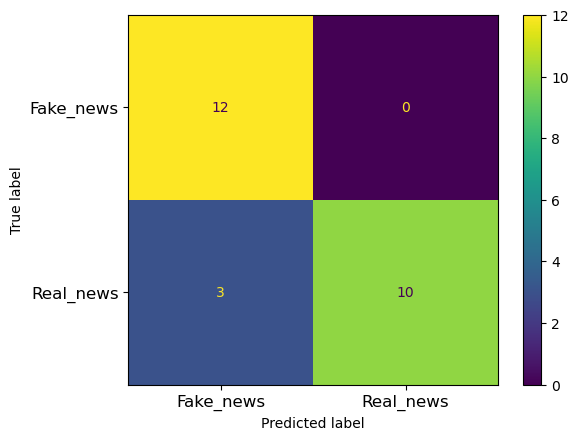

In [224]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.3.5 Method_2 Test_5

In [225]:
# assign X and y
X_train = news.text
y_train = news.label
X_test = test.text
y_test = test.label

In [226]:
# Initialize a CountVectorizer object: count_vectorizer
cv_kwargs = dict(ngram_range=(1,2), max_df=0.8, min_df=0.1)
count_vectorizer = CountVectorizer(**cv_kwargs)

In [227]:
# Transform the training data using only the 'text' column values: count_train 
count_X_train = count_vectorizer.fit_transform(X_train)

In [228]:
# Transform the test data using only the 'text' column values: count_test 
count_X_test = count_vectorizer.transform(X_test)

In [229]:
count_X_train.shape, count_X_test.shape

((37546, 382), (25, 382))

In [230]:
# initiate the model
lr_classifier = LogisticRegression()
# fit the model
lr_classifier.fit(count_X_train, y_train)

LogisticRegression()

In [231]:
y_test_pred = lr_classifier.predict(count_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [232]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.88
The test set precision score is 0.857
The test set recall score is 0.923


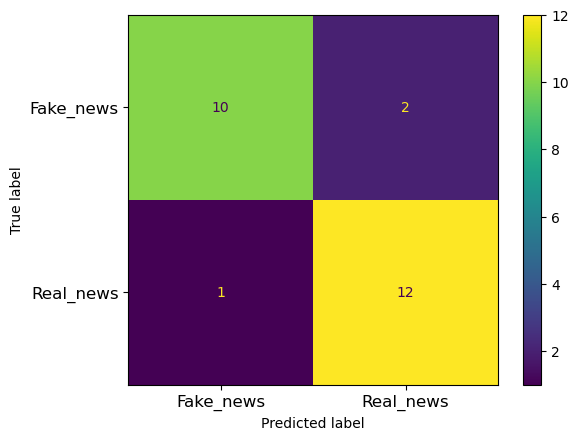

In [233]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

### 3.3.4 Method_2 Test_6

In [234]:
# assign X and y
X_train = news.text
y_train = news.label
X_test = test.text
y_test = test.label

In [235]:
# Initialize a TfidfVectorizer object: tfidf_vectorizer
cv_kwargs = dict(ngram_range=(1,1), min_df=0.1)
tfidf_vectorizer = TfidfVectorizer(**cv_kwargs)

In [236]:
# Transform the training data using only the 'text' column values: tfidf_train 
tfidf_X_train = tfidf_vectorizer.fit_transform(X_train)

In [237]:
# Transform the test data using only the 'text' column values: tfidf_test 
tfidf_X_test = tfidf_vectorizer.transform(X_test)

In [238]:
tfidf_X_train.shape, tfidf_X_test.shape

((37546, 300), (25, 300))

In [239]:
# initiate the model
lr_classifier = LogisticRegression()
# fit the model
lr_classifier.fit(tfidf_X_train, y_train)

LogisticRegression()

In [240]:
y_test_pred = lr_classifier.predict(tfidf_X_test)
test_accuracy = metrics.accuracy_score(y_test, y_test_pred)
test_recall = metrics.recall_score(y_test, y_test_pred, pos_label='real_news')
test_precision = metrics.precision_score(y_test, y_test_pred, pos_label='real_news')

In [241]:
print(f"The test set accuracy is {round(test_accuracy,3)}")
print(f"The test set precision score is {round(test_precision,3)}")
print(f"The test set recall score is {round(test_recall,3)}")

The test set accuracy is 0.92
The test set precision score is 0.923
The test set recall score is 0.923


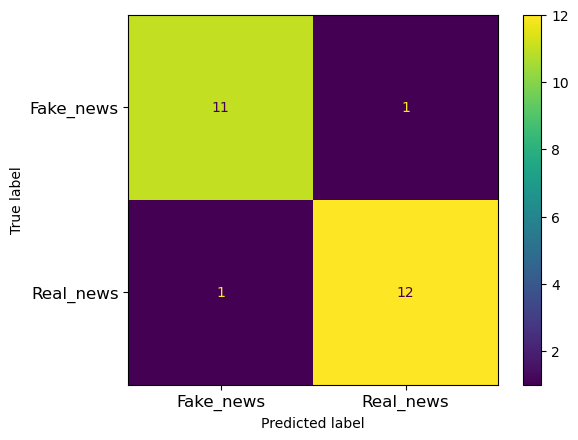

In [242]:
cm = metrics.confusion_matrix(y_test, y_test_pred, labels = lr_classifier.classes_)
fig, ax = plt.subplots()
display_cm = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, 
                                    display_labels = ['Fake_news', 'Real_news'])

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)
ax.set_yticklabels(labels = ['Fake_news', 'Real_news'], fontsize = 12)

display_cm.plot(ax = ax)
plt.show()

# 4. Output

In [243]:
pd.DataFrame(hyperparameter_table).set_index('Exp').to_csv('../Data/hyperparameter_table_Feb29_2024.csv')

In [244]:
news.to_csv('../Data/news_classification_Feb29_24.csv')

# 5. Conclusion

**Based on the test performance result:** 

**Method_1 Test_1 with features like character count, word count in text and title etc, accuracy is 0.72, precision score is 0.80,  recall score 0.615.** 

**Method_1 Test_2 with features like character count, word count in text and title etc, accuracy is 0.8, precision score is 0.833,  recall score 0.769.**    

**1. Method_2 Test_3 with CountVectorizer(ngram=1), accuracy is 0.92, precision score is 1.0, which means all fake news are correctly labelled, only two real news are falsely labelled as fake news, result in recall score 0.846.**      

**2. Method_2 Test_4 with TfidfVectorizer(ngram=1), accuracy is 0.88, but also have precision score 1.0, three real news are falsely labelled as fake news, which result in recall score 0.769.**  

**3. Method_2 Test_5  with CountVectorizer(ngram=1-2, max_df=0.8, min_df=0.1), accuracy is also 0.88, but precision score 0.857, however, the recall score increased to 0.923.**

**4. Method_2 Test_6 with TfidfVectorizer(ngram=1, min_df=0.1), accuracy is also 0.92, but precision score 0.923 is not the best or the worst, the recall score also increased to 0.923, the results show this is a moderate model.**

**Concluded that the method 2 performs better than method 1.**